# A Bayesian Neural Network (BNN) with uncertainty

The goal is handwritten digit recognition (MNIST), with a twist. The *Bayesian* NN is able to refuse classifying images if they are ambiguous- and may entirely refuse to classify images that are unlike anything it has seen before (consider for example how a traditional NN that does not leverage uncertainty would output overly-confident labels when given, say images of cars despite being trained on airplanes).

Sources: 

https://github.com/paraschopra/bayesian-neural-network-mnist.git

https://github.com/kumar-shridhar/PyTorch-BayesianCNN.git

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

May need to install this module to import the 'imread' module.

In [4]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 98kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [0]:
%matplotlib inline 
#matplotlib graphs will be included in notebook, next to the code.

Load in the MNIST dataset, splitting up into train and test data:


In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

Now define the BNN model (using the PyTorch approach):



In [0]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

Flattened 28*28 image:

In [0]:
net = NN(28*28, 1024, 10)

In [0]:
!pip3 install pyro-ppl

In [0]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

softmax classifier, with log-probabilites... these will be exponentiated later to retrieve the predicted probabilities.

In [0]:
log_softmax = nn.LogSoftmax(dim=1)

In [0]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

The model() function defines how the output data is generated.
In our classifier, the 10 output values corresponding to each digit are generated when we run the neural network (initialised in the net variable above)with a flattened 28*28 pixel image. 

Within model(), the function pyro.random_module() converts parameters of our neural network (weights and biases) into random variables that have the initial (prior) probability distribution given by fc1w_prior, fc1b_prior, outw_prior and outb_prior (in our case, as you can see, initalized with a normal distribution).

The next code block defines the variational distribution (which acts as a surrogate) for approximating the true posterior.

This guide() function describes the Z parameters (like mean and variance of weights and biases) that can be changed to see if resultant distribution closely approximates the posterior that comes out of model().

In [0]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

The optimizer is Adam, and the loss function is the ELBO- maximizing it is equivalent to minimizing the KL divergence between the 'guide' variational posterior, and the true posterior distributions.

In [0]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

Optimization loop:

In [12]:

num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:371: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  2099.884098832091
Epoch  1  Loss  376.6117188729922
Epoch  2  Loss  159.6446375751972
Epoch  3  Loss  111.69747827866873
Epoch  4  Loss  96.00174148570696


Once the loss seems to be stabilizing / converging to a value, we can stop the optimization and check the accuracy of the BNN:

# Uncertainty measures

reference: *Shridhar et al*

In [32]:
import torch.nn.functional as F
import tensorflow as tf

In [0]:
def normalization_function(x):
    return (x) / torch.sum(x, dim=0)

In [0]:
def calc_uncertainty_normalized(output):
    outputs = []
    for t in range(1):
        #prediction = F.softplus(output.cpu()) ####
        prediction = normalization_function(output)
        outputs.append(prediction)
        
    res = np.mean(prediction.numpy(), axis=0)
    p_hat= torch.cat(outputs, 1)
    p_hat=p_hat.numpy()
    T=1
    
    aleatoric = np.diag(res) - p_hat.T.dot(p_hat)/p_hat.shape[0]
#     aleatoric += aleatoric
    tmp = p_hat - res  
    epistemic = tmp.T.dot(tmp)/tmp.shape[0]
#     epistemic += epistemic 

    print(np.sum(epistemic, keepdims = True))
    print(np.sum(aleatoric, keepdims = True))

#     p_hat = np.array(res)
#     print (p_hat)
#     epistemic = np.mean((p_hat) ** 2, axis=0) - np.mean((p_hat), axis=0) ** 2
#     epistemic = np.mean((1-p_hat) ** 2, axis=0) - np.mean((1-p_hat), axis=0) ** 2
#    epistemic += epistemic 
#     #print (epistemic)
#     aleatoric = np.mean((p_hat) * (1-(p_hat)), axis = 0)
#     aleatoric = np.mean((1-p_hat), axis = 0) ** 2
#     aleatoric += aleatoric
    #print (aleatoric)
    return (np.sum(epistemic, keepdims = True)), (np.sum(epistemic, keepdims = True))

In [0]:
def calc_uncertainity_softmax(output):
    prediction = F.softmax(output, dim = 1)
    results = torch.max(prediction, 1 )
    p_hat = np.array(results[0].cpu().detach())
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
#     epistemic += epistemic 
    #print (epistemic)
    aleatoric = np.mean(p_hat * (1-p_hat), axis = 0)
#     aleatoric += aleatoric
    #print (aleatoric)
    return epistemic, aleatoric

In [94]:
#how many times should we sample weights from the estimated posterior during predictions? i.e. sample num_samples neural networks each time
#you make a prediction. this is what enables us to give uncertainities on outputs
num_runs = 5
num_samples = 10

accuracy_runs = []
epistemic_runs = []
aleatoric_runs = []

def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #would need an average epistemic and aleatoric uncertainty for each of these models...
    # print(yhats)
    # print(len(yhats), type(yhats))
    epistemic_uncertainties = []
    aleatoric_uncertainties = []
    for mod in sampled_models:
      output = mod(x)
      #print(output)
      #for each model, use the outputs to calculate uncertainties
      epistemic , aleatoric = calc_uncertainity_softmax(output)
      epistemic_uncertainties.append(epistemic)
      aleatoric_uncertainties.append(aleatoric)
    avg_epistemic = np.mean(epistemic_uncertainties)
    avg_aleatoric = np.mean(aleatoric_uncertainties)
    return np.argmax(mean.numpy(), axis=1), avg_epistemic, avg_aleatoric

for i in(range(num_runs)):
  print('Run %d:' % (i+1))
  correct = 0
  total = 0
  #batch size is 128
  #128*78 = 9984; there are 10,000 test set images so j goes from 0-78 to pass through all MNIST images. Each of the 128-image batches
  #contains unique images
  for j, data in enumerate(test_loader):
      images, labels = data
      predicted, epistemic, aleatoric  = predict(images.view(-1,28*28))
      total += labels.size(0)
      labels = np.array(labels) #must be cast to np.array() so that the comparison can be made between this and 'predicted' when counting correct preditions..
      #predicted and labels are both np.arrays of 128 elements representing the predictions and true labels of the 128-image batch
      #epistemic , aleatoric = calc_uncertainity_softmax(outputs)
      correct += (predicted == labels).sum().item()
  accuracy_runs.append(100 * correct / total)
  epistemic_runs.append(epistemic)
  aleatoric_runs.append(aleatoric)

avg_accuracy = np.mean(accuracy_runs)
avg_epistemic = np.mean(epistemic_runs)
avg_aleatoric = np.mean(aleatoric_runs)

print("Avg. accuracy: %d" % (avg_accuracy), "\n Correct predictions: %d, out of a total of  %d images in the test set" % (int(avg_accuracy*100), 10000)) 
print("Epistemic Uncertainty: %f" % (avg_epistemic))
print("Aleatoric Uncertainty: %f" % (avg_aleatoric))


Prediction when network is forced to predict:


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:371: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Prediction when network is forced to predict:
Prediction when network is forced to predict:
Prediction when network is forced to predict:
Prediction when network is forced to predict:
Avg. accuracy: 89 
 Correct predictions: 896679, out of a total of  10000 images in the test set
Epistemic Uncertainty: 0.001143
Aleatoric Uncertainty: 0.003845


When forcing the network to classify, it has an average accuracy of approximately 89%, as it gets about 8,850 predictions right (out of 10,000). Across 5 runs.

Epistemic Uncertainty: 0.003118
Aleatoric Uncertainty: 0.006799

The predict() function uses the learned guide() function (and not the model() function) to do predictions. 

Note that when making predictions, epistemic and aleatoric uncertainties are averaged over all the sampled models, and returned as single scalars along with average accuracy.

This is because for model(), all we know are the priors for weights and not the posterior. 

For guide(), i.e. the variational posterior, it approximates the true posterior better and better the more training iterations there are, so it can be used as a surrogate for making predictions instead of the true posterior.

In [0]:
#10 classes
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 10
threshold = 0.3
def give_uncertainties(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]

    epistemic_uncertainties = []
    aleatoric_uncertainties = []
    for mod in sampled_models:
      output = mod(x)
      #print(output)
      #for each model, use the outputs to calculate uncertainties
      epistemic , aleatoric = calc_uncertainity_softmax(output)
      epistemic_uncertainties.append(epistemic)
      aleatoric_uncertainties.append(aleatoric)
    avg_epistemic = np.mean(epistemic_uncertainties)
    avg_aleatoric = np.mean(aleatoric_uncertainties)
    #print(avg_epistemic, avg_aleatoric)

    return np.asarray(yhats), avg_epistemic, avg_aleatoric
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1), avg_epistemic, avg_aleatoric



Now the goal is to somehow get the network to think twice about making predictions. That is, if an image is passed in during test time which looks quite unlike anything before it (in statistical terms, this means that the test distribution differs from the training distribution since a sample was just drawn from it which probably finds no analogue in the training distribution). 

The core of uncertainty is that the test set and training set distributions *differ*- so we can leverage this uncertainty to get the network to **not** predict on those test examples that are too different.

To do that, at test time when an image is passed in: 

- draw *num_samples* samples of weights (i.e. define *num_samples* different networks) and thus obtain *num_samples* outputs
- convert those outputs (which are logsoftmaxed) into probabilities by exponentiating them
- thus for each test image, and for *each* digit, there are *num_samples* probabilities
-  Find the median probability value of this list of probabilities
- If the median > threshold, the network will go ahead with the prediction.

# therefore...

Whether or not the network will make predictions will be a function of two things: *num_samples* and *threshold*. The first controls how many times weights are sampled from the (approximate) posterior at test time- effectively defining different networks, and acting as model averaging. The second is how confident we want the network to be: the higher this value, the more confident the network will have to feel before making predictions.

In [0]:
def test_batch(images, labels, plot=True):
    y, epistemic, aleatoric = give_uncertainties(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>threshold): #select if network thinks this sample is at least threshold% probability of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
        
    return len(labels), correct_predictions, predicted_for_images, epistemic, aleatoric

In [102]:
# Prediction when network can decide not to predict
num_runs = 5
skipped_runs = []
accuracy_runs = []
epistemic_runs = []
aleatoric_runs = []
total_predicted_runs = []
total_correct_runs = []

print('Prediction when network can refuse:')
for i in(range(num_runs)):
  print('Run %d:' % (i+1))
  correct = 0
  total = 0
  total_predicted_for = 0
  for j, data in enumerate(test_loader):
      images, labels = data
      total_minibatch, correct_minibatch, predictions_minibatch, epistemic, aleatoric  = test_batch(images.view(-1,28*28), labels, plot=False)
      total += total_minibatch
      correct += correct_minibatch
      total_predicted_for += predictions_minibatch
  skipped_runs.append(total-total_predicted_for)
  accuracy_runs.append(100 * correct / total_predicted_for)
  epistemic_runs.append(epistemic)
  aleatoric_runs.append(aleatoric)
  total_predicted_runs.append(total_predicted_for)
  total_correct_runs.append(correct)
  print("Epistemic:", epistemic)
  print("Aleatoric:", aleatoric)
  print("Skipped:", total-total_predicted_for)
avg_accuracy = np.mean(accuracy_runs)
avg_epistemic = np.mean(epistemic_runs)
avg_aleatoric = np.mean(aleatoric_runs)
avg_skipped = int(np.mean(skipped_runs))
avg_predictions = int(np.mean(total_predicted_runs))
avg_correct = int(np.mean(total_correct_runs))


print("On average, skipped: ", avg_skipped)
print("Average accuracy when allowed to refuse: %d %%" % (avg_accuracy), "Correct: %d, out of: %d" % (avg_correct , avg_predictions))
print("Epistemic Uncertainty: %f" % (avg_epistemic))
print("Aleatoric Uncertainty: %f" % (avg_aleatoric))

Prediction when network can refuse:
Run 1:


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:371: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epistemic: 0.00040919274314745737
Aleatoric: 0.0022898535
Skipped: 981
Run 2:
Epistemic: 0.001641291641310616
Aleatoric: 0.003585155
Skipped: 982
Run 3:
Epistemic: 0.0014991102716173544
Aleatoric: 0.0034104981
Skipped: 970
Run 4:
Epistemic: 0.001193658829205546
Aleatoric: 0.004966689
Skipped: 977
Run 5:
Epistemic: 0.005716558218814072
Aleatoric: 0.012549227
Skipped: 963
On average, skipped:  974
Average accuracy when allowed to refuse: 92 % Correct: 8359, out of: 9025
Epistemic Uncertainty: 0.002092
Aleatoric Uncertainty: 0.005360


Now the network achieves an average of 95% accuracy across 5 runs.

Note that this is calculated only on images that it is confident about. In other words, it's a form of conditional accuracy, where the test set has been reduced to exclude questionable images.

In [0]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:371: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Real:  7


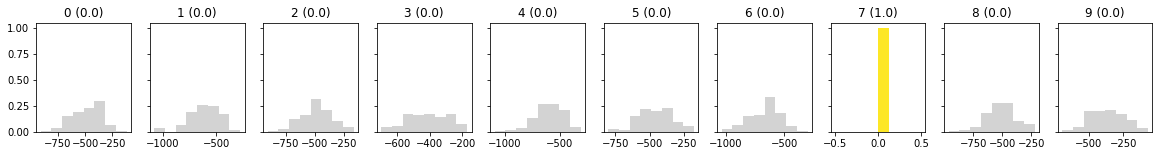

Correct


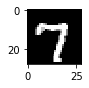

Real:  8


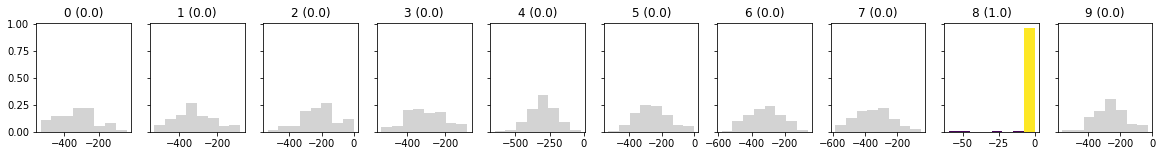

Correct


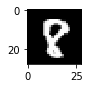

Real:  7


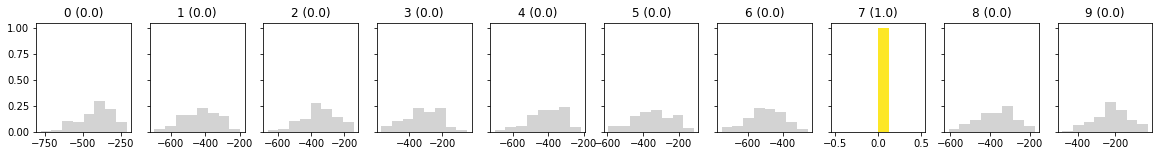

Correct


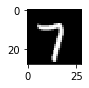

Real:  7


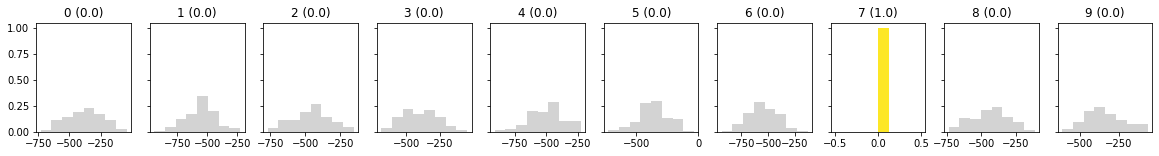

Correct


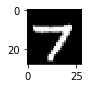

Real:  7


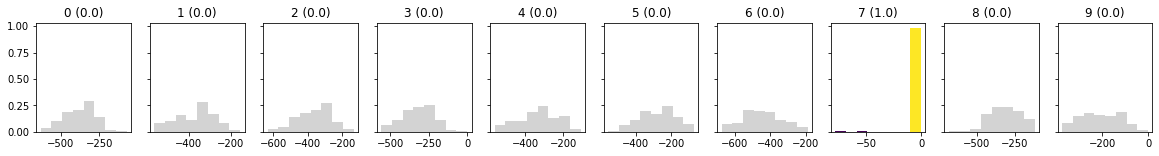

Correct


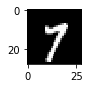

Real:  6


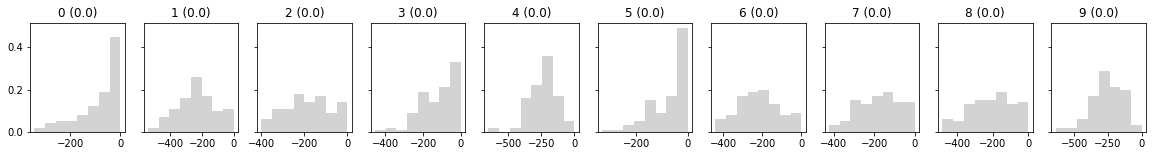

Undecided.


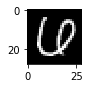

Real:  5


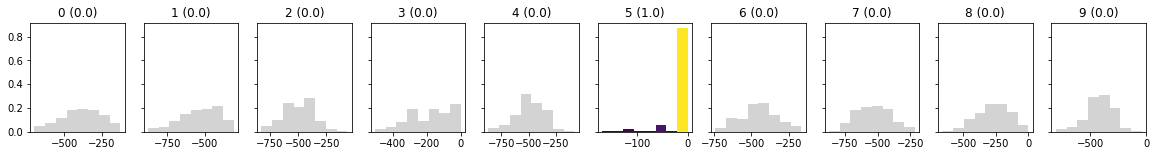

Correct


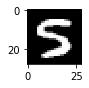

Real:  5


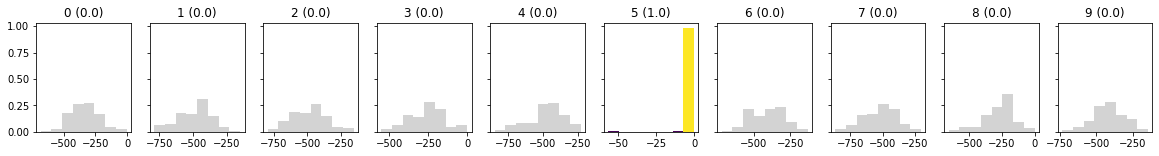

Correct


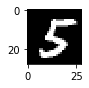

Real:  1


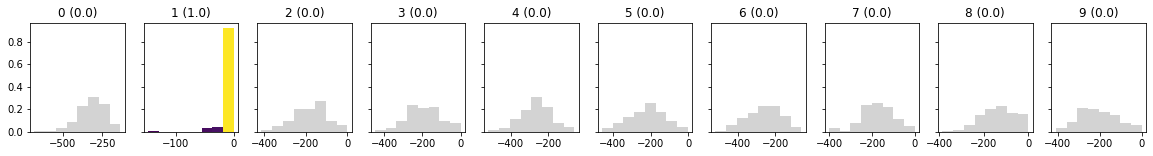

Correct


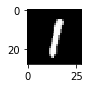

Real:  3


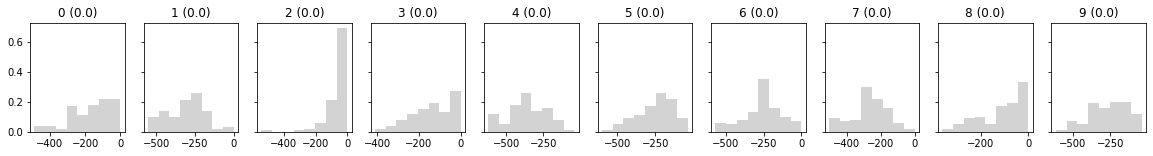

Undecided.


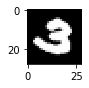

Summary
Total images:  10
Predicted for:  8
Accuracy when predicted:  1.0


(10, 8.0, 8)

In [0]:
test_batch(images[:10], labels[:10])

Make predictions on random images.

In [0]:
# generate random data

images_random = torch.rand(2,28,28)
labels_random = torch.randint(0,10, (2,))

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:371: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Real:  5


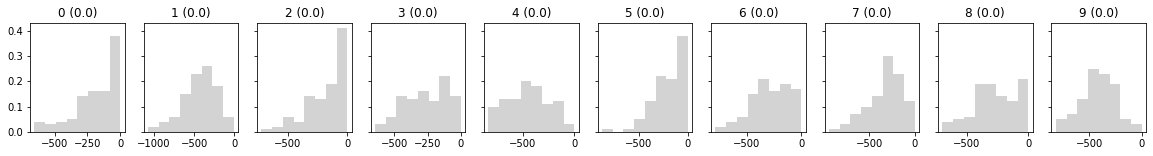

Undecided.


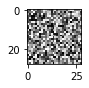

Summary
Total images:  1
Predicted for:  0


ZeroDivisionError: ignored

In [0]:

test_batch(images_random, labels_random)